In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import glob
import pmefm
reload(pmefm)
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
import sigutils
from kpfm import lockin
from kpfm import util
reload(util)
reload(lockin)

ks = 14950.0

@h5filename
def _h5toPMEFM(f):
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.167 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

In [2]:
fh = h5py.File('../data/KPFM-linescans/170217-1657DPh-BTBT-20V-50-nm-x-mod.h5', 'r')

In [3]:
d = _h5toPMEFM(fh)
ks = d['fs'] / d['v_tip']
fir2 = lockin.lock2(4.5/d['v_tip'], 1.1 , 1.1*4, ks)

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   6.063 0.002  -53.440
   8.800 0.000 -101.830
  12.126 0.000 -114.106
11037.642 0.000 -344.861


In [4]:
CPD = signal.fftconvolve(fh['CPD'][:], fir2, 'valid')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.093087463469
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9


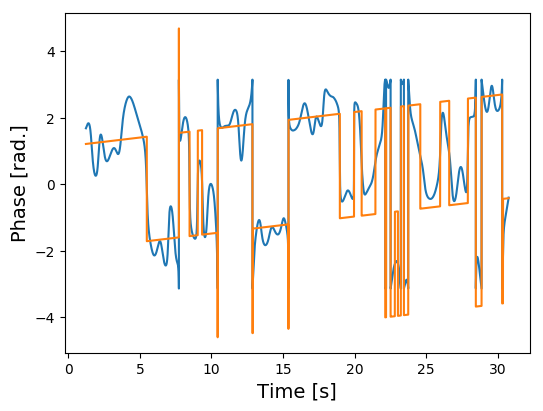

In [5]:
p25 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1631DPh-BTBT-20V-25-nm-mod-x.h5'))
p25.fir_filter(fir_ac=fir2, fir_dc=fir2)
p25.auto_phase()
p25.plot_phase()
p25.output()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0855476269131
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6


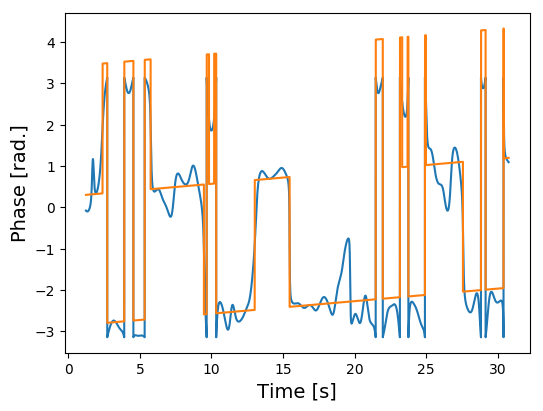

In [6]:
p50 = pmefm.PMEFMEx(**_h5toPMEFM('../data/KPFM-linescans/170217-1628DPh-BTBT-20V-50-nm-mod-x.h5'))
p50.fir_filter(fir_ac=fir2, fir_dc=fir2)
p50.auto_phase()
p50.plot_phase()
p50.output()

In [7]:
li = lockin.LockIn(p50.t, p50.phi)

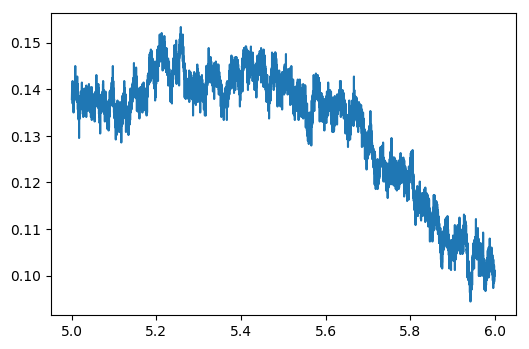

In [8]:
mask = (p50.t > 5) & (p50.t < 6)

plt.plot(p50.t[mask], p50.phi[mask])

In [9]:
m = kpfm_data("../data/KPFM/Feb 17 15-54  image 1.txt")

In [10]:
m.dx = np.mean(np.gradient(m.vx)) * 0.125
m.dy = np.mean(np.gradient(m.vy)) * 0.125

In [11]:
Ex, Ey = np.gradient(m.ch1)
m.Ex, m.Ey = Ex/m.dx, Ey/m.dy

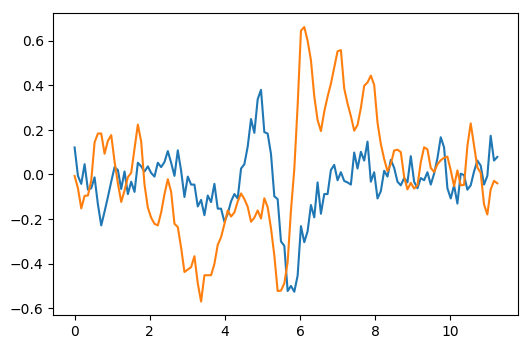

In [12]:
plt.plot((m.vy-m.vy[0])  * 0.125, m.Ex[14])
plt.plot((m.vy-m.vy[0]) * 0.125, -m.Ey[14])

Response:
f   mag       dB
0.000 1.000   -0.000
0.550 0.981   -0.163
1.000 0.937   -0.564
1.100 0.923   -0.692
2.000 0.736   -2.661
4.400 0.106  -19.494
8.800 0.000 -111.403
10.000 0.000 -327.647


(<matplotlib.figure.Figure at 0x1027e3210>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x115fbe490>,
  <matplotlib.axes._subplots.AxesSubplot at 0x11e24e410>))

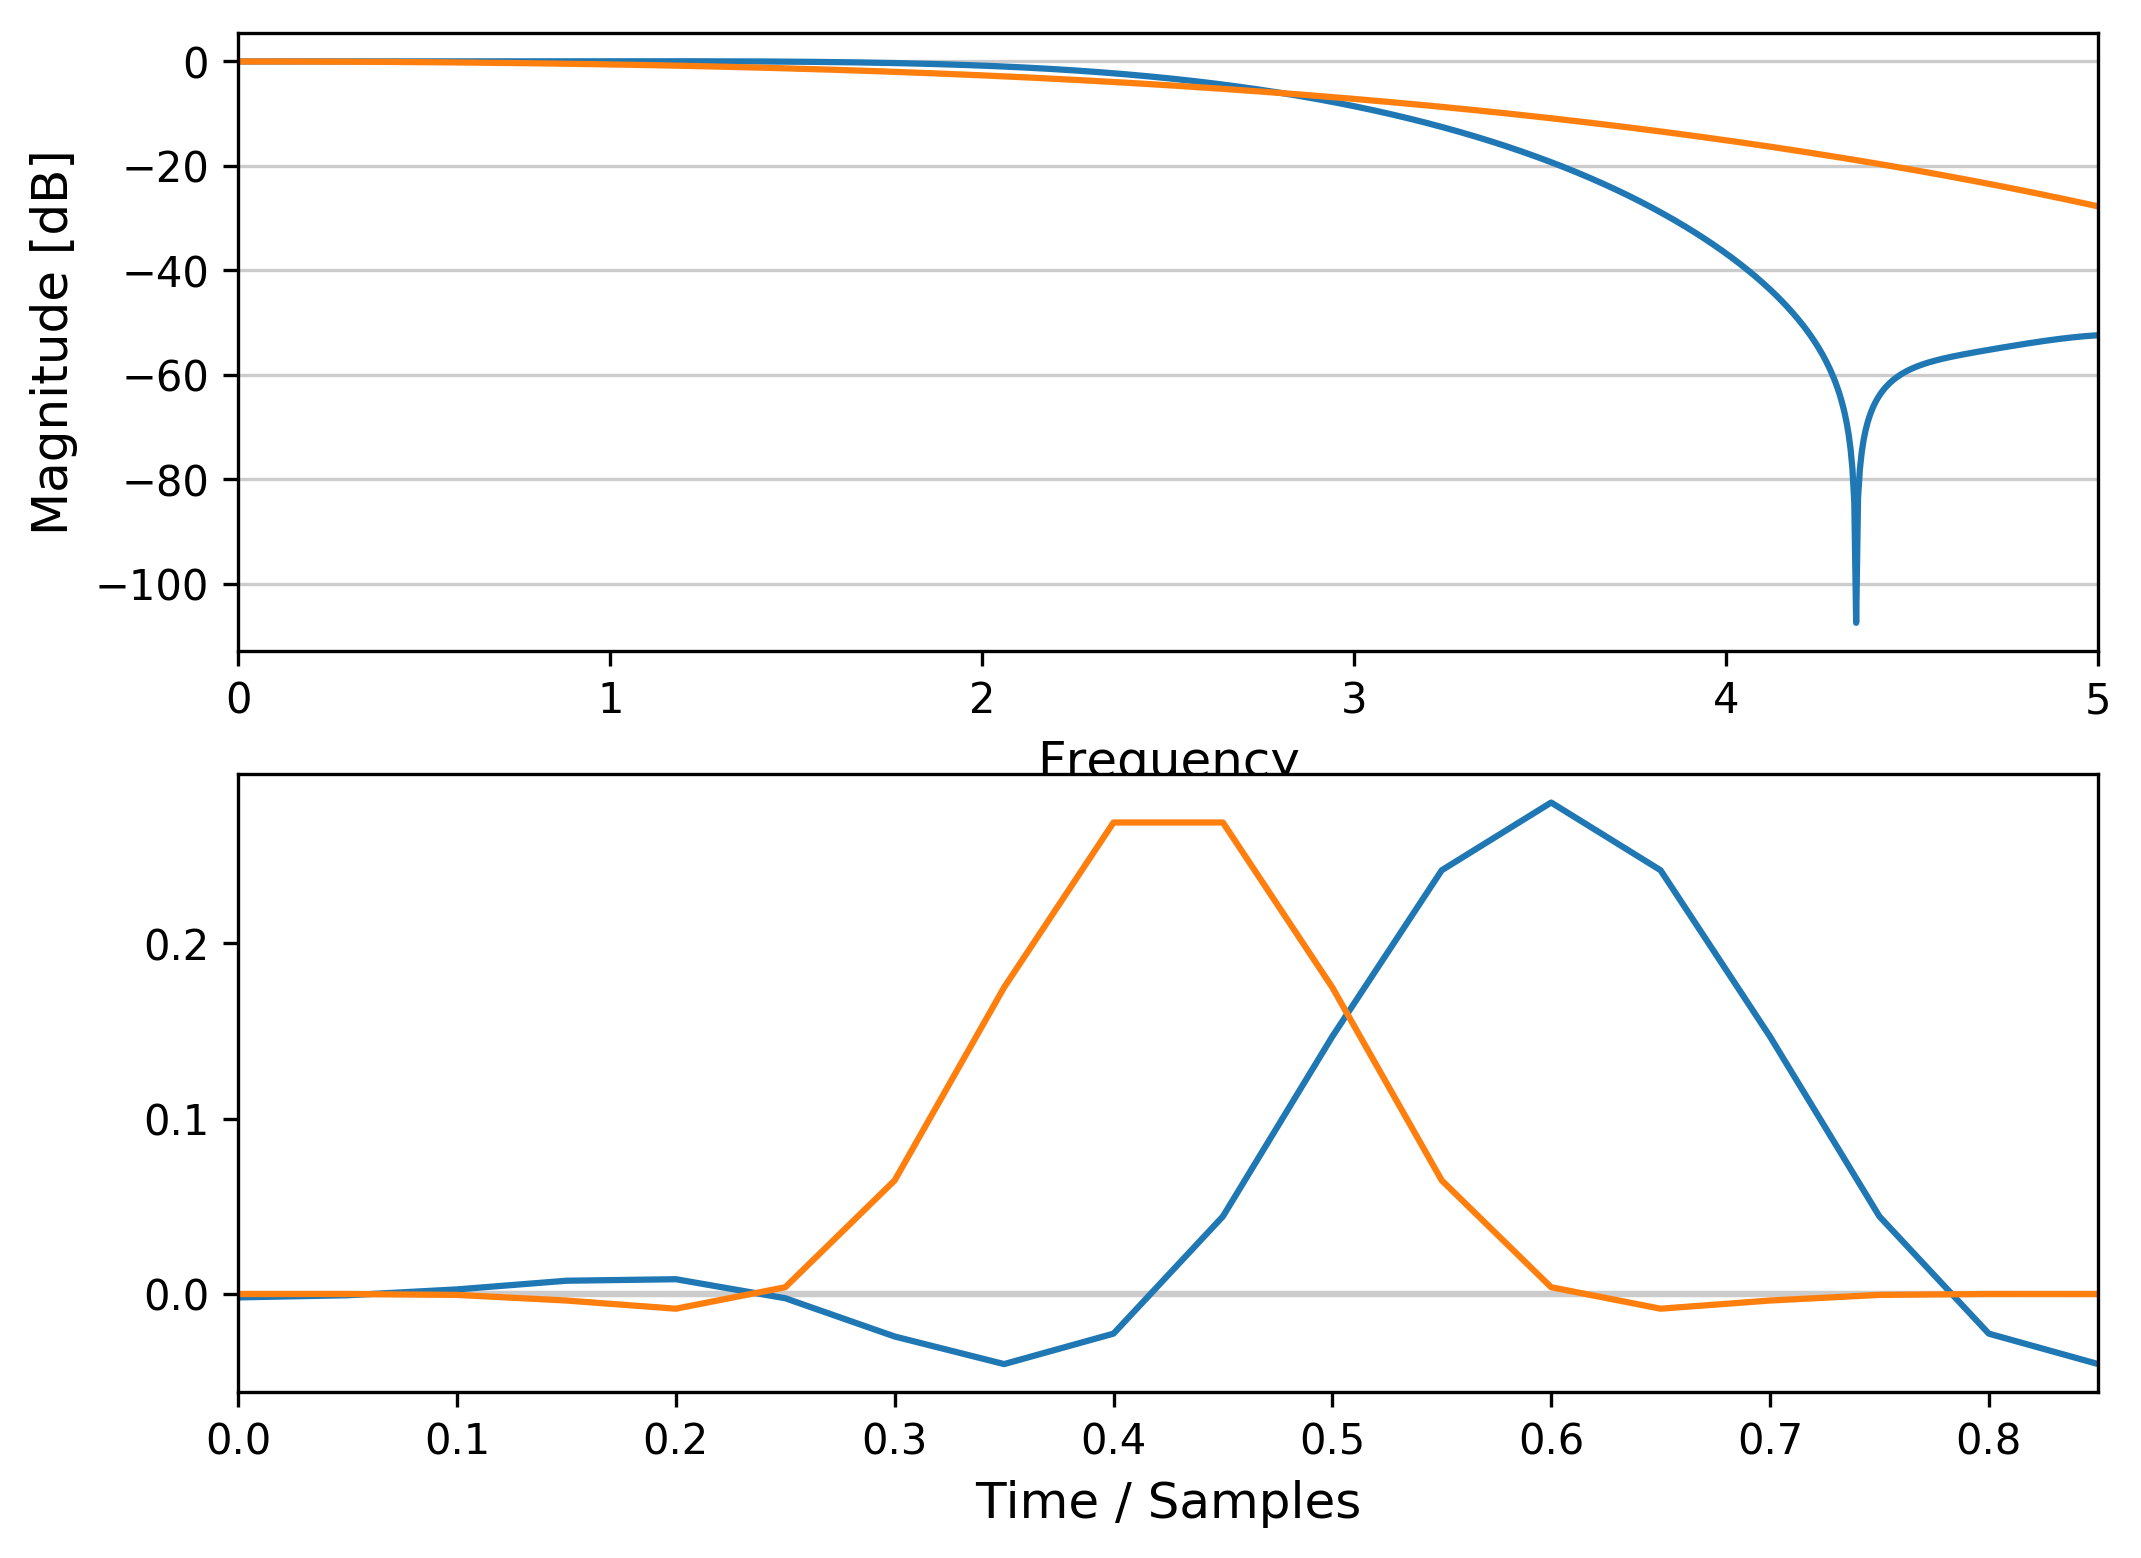

In [13]:
h = signal.firwin(25, 2.8, nyq=10)
h3 = lockin.lock2(2, 1.1, 4.4, 20)
h2 = signal.firwin(21, 1.9, nyq=0.5/0.05,)
sigutils.magtime_firs([h, h3], fs=20, freq_lim=(0, 5.0))

In [14]:
nu_s = 1/0.05 # µm

C = np.zeros((15, 9))
r = (np.arange(9) - 4)*0.09
r2 = (np.arange(15) - 7)*0.05

for i, ival in enumerate(r2):
    for j, jval in enumerate(r):
        C[i, j] = np.exp(-(abs(ival) + abs(jval))**2/((0.8/(2*np.pi))**2))
C = C/np.sum(C)
m.ch1_filt = signal.convolve2d(m.ch1, h3.reshape(-1, 1), mode='same')

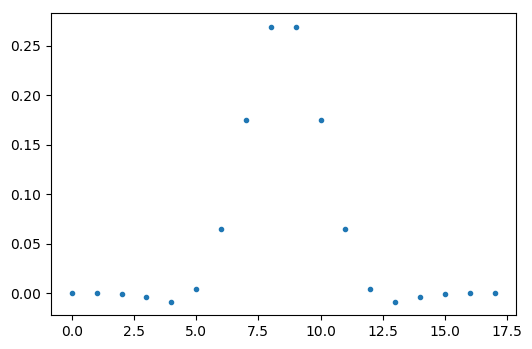

In [15]:
plt.plot(h3, '.')

In [16]:
# This is already quite filtered in the scan direction.
# Perhaps just add a filter in the opposite direction?

In [17]:
Ex_filt, Ey_filt = np.gradient(m.ch1_filt)
m.Ex_filt, m.Ey_filt = Ex_filt/m.dx, Ey_filt/m.dy

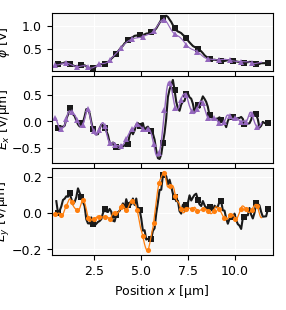

In [18]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig = plt.figure()
fig, axes = plt.subplots(nrows=3, figsize=(2.85, 3.2), sharex=True,
                         gridspec_kw=dict(height_ratios=(1, 1.5, 1.5)),
                        subplot_kw=dict(facecolor='0.97'))
axV = axes[0]
axEx = axes[1]
axEy = axes[2]

fig.subplots_adjust(hspace=0.063)

for ax in axes:                
    ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)

dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5

i = 11

# ax1.plot(efm('x_dc')[::dec], efm('E_dc')[::dec], '0.2', linewidth=1.1)
# ax1.plot(efm('x_dc')[::(dec_pts*dec)],
#              efm('E_dc')[::(dec_pts*dec)],
#              linewidth=0, marker='s', markersize=1.2*scale, mew=0, alpha=1, color='0.2')
# ax2.plot(efm('x_dc')[::dec], efm('phi_dc')[::dec], '0.2', linewidth=1.1)
# ax2.plot(efm('x_dc')[::(dec_pts*dec*2)], efm('phi_dc')[::(dec_pts*dec*2)], '0.2',
#          linewidth=0, marker='s', markersize=1.35*scale, mew=0, alpha=1, color='0.2')

c1 = u'#9467bd'
c2 = '#ff7f0e'



axV.plot((m.vy-m.vy[0])  * 0.125 + 0.5, m.ch1[i], color='0.1', alpha=1)
axV.plot((m.vy-m.vy[0])[1::7]  * 0.125 + 0.5, m.ch1[i][1::7],
         '0.1',
         linewidth=0, marker='s', markersize=1.35*scale, mew=0, alpha=1, color='0.1')

my = slice(4, -4)



# axEy.plot((m.vy-m.vy[0])  * 0.125 + 0.5, -m.Ex[14], color='y', alpha=0.5)
# axEy.plot((m.vy-m.vy[0])  * 0.125 + 0.5, -m.Ex[14], color='g', alpha=0.4)
# axEy.plot((m.vy-m.vy[0])[my]  * 0.125 + 0.5, -m.Ex_filt[14][my], color='g', alpha=1)
axEy.plot((m.vy-m.vy[0])  * 0.125 + 0.5, -m.Ex_filt[i], color='0.1', alpha=1)
axEy.plot((m.vy-m.vy[0])[1::7]  * 0.125 + 0.5, -m.Ex_filt[i][1::7],
         '0.1',
         linewidth=0, marker='s', markersize=1.35*scale, mew=0, alpha=1, color='0.1')

mx = slice(6, -6)

# axEx.plot((m.vy-m.vy[0]) * 0.125 + 0.5, -m.Ey[14], color='b', alpha=0.4)
axEx.plot((m.vy-m.vy[0]) * 0.125 + 0.5, -m.Ey[i], color='0.1', alpha=1)
axEx.plot((m.vy-m.vy[0])[1::7] * 0.125 + 0.5, -m.Ey[i][1::7], color='0.1', alpha=1,
          linewidth=0, marker='s', markersize=1.35*scale, mew=0)
# axEx.plot((m.vy-m.vy[0])[mx] * 0.125 + 0.5, -m.Ey_filt[14][mx], color='b', alpha=1)

for efm in [p50]:
    line, = axEx.plot(efm('x_dc')[::dec], efm('E_dc')[::dec], alpha=1, linewidth=1, color=c1)
    axEx.plot(efm('x_dc')[i::(dec_pts*dec)],
             efm('E_dc')[i::(dec_pts*dec)],
             linewidth=0, marker='^', mew=0, markersize=1.35*scale, alpha=1, color=line.get_color())
    line2, = axEy.plot(efm('x_dc')[::dec], -efm('E_mod')[::dec], alpha=1, linewidth=0.9, color=c2)
    axEy.plot(efm('x_dc')[i::(dec_pts*dec)],
             -efm('E_mod')[i::(dec_pts*dec)],
             linewidth=0, marker='.', markersize=2.1*scale, mew=0,
              alpha=1, color=line2.get_color())

    axV.plot(efm('x_dc')[::dec], efm('phi_dc')[::dec],
             alpha=1, linewidth=0.8, color=c1)
    axV.plot(efm('x_dc')[i::(dec_pts*dec*2)], efm('phi_dc')[i::(dec_pts*dec*2)],
             alpha=1, linewidth=0, marker='^', mew=0,
             markersize=1.35*scale, color=c1)

    

    
    
axEx.set_ylabel(u"$E_{x}$ [V/µm]")
axEy.set_ylabel(u"$E_{y}$ [V/µm]")
axes[-1].set_xlabel(u"Position $x$ [µm]")
axes[-1].set_xlim(0.25, 12)
axV.set_ylabel(u"$\\phi$ [V]")
util.align_labels(axes, 12)
# ax1.set_xlim(0.4, 13.0)
# ax2.set_xlim(0.4, 13.0)
# ax1.set_xticks(np.arange(2, 13.6, 2))
# ax2.set_xticks(np.arange(2, 13.6, 2))
# # ax1.set_ylim(-0.7, 2)
# ax1.set_yticks(np.arange(0, 2.1, 1))
# ax1.set_yticklabels(['0', '1', ''])
# ax1.set_yticks(np.arange(-0.5, 1.6, 1), minor=True)

In [19]:
fig.savefig("../figs/03cde-pm-kpfm-perp.pdf", bbox_inches='tight', pad_inches=0.25)